In [149]:
%matplotlib inline
import matplotlib
import argparse
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
import sys
import colorbrewer as cb
import math
import fnmatch
import os


def list_files_or_dir(file_or_dir_list, prefix='*', suffix='*', containing='*'):
    if type(file_or_dir_list) != list: return [file_or_dir_list]
    files = []
    for file_or_dir in file_or_dir_list:
        if os.path.isdir(file_or_dir):
            for root, dirnames, filenames in os.walk(file_or_dir):
                for filename in fnmatch.filter(filenames, '%s*%s*%s' % (prefix, containing, suffix)):
                    files.append(os.path.join(root, filename))
        else:
            files.append(file_or_dir)
    return files


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb


def get_n1(n1_files, rep_name):
    for n1_file in n1_files:
        if rep_name in n1_file:
            return pkl.load(open(n1_file))[0]


def add_method(method_name, method_num, targetdir, group_folder):
    print "Processing %s ..." % method_name
    ratios = list_files_or_dir([targetdir], prefix='ratios', containing=method_name)
    n1s = list_files_or_dir([targetdir], prefix='n1', containing=method_name)
    rep_names = [fie.split('/')[-2] for fie in ratios]

    bins_area=200
    bins_all=[]
    bins_n1=[]
    n_list=[]
    n_group = 0
    # plot the lines of all ratios (pairs of ranks)
    for i, ratio_path in enumerate(ratios):
        alpha_plt=0.6
        ratio = np.array(pkl.load(open(ratio_path)))
        numevents = ratio.shape[0]
        if group_folder in rep_names[i]:
            #alpha_plt=.9
            #plot the diagonal if we are in the first step
            diagonal = np.linspace(0, 1, num=numevents+1)
            plt.plot(diagonal, diagonal, '--', color="#cccccc")
            plt.plot(np.linspace(0, 1, len(ratio)), ratio, '-', label="%s Groups - %.0f%% (N=%d)" % (method_name.upper(), math.ceil(ratio[-1]*100), numevents) , linewidth=4, color=rgb_to_hex(cb.Paired[10][2*method_num + 1]), alpha=1)
            n_group = numevents
            continue

        n_list.append(len(ratio))
        aux=[]
        for aa in xrange(0,bins_area,1):
            aux.append(ratio[int((aa/(bins_area*1.0))*len(ratio))])
        bins_all.append(aux)

        n1 = get_n1(n1s, rep_names[i])
        bins_n1.append(np.arange(0, len(ratio)*1./n1, 1./n1)[:len(ratio)])

    print "[%s] Avg. N=%.2f" % (method_name, np.mean(n_list))
    if n_group:
        print "[%s group] N=%d" % (method_name, n_group)
    ndbins=np.array(bins_all, ndmin=2)
    nbins_n1=np.array(bins_n1)
    label_met = "%s Pairs mean - %.0f%% (Avg. N=%.0f)" % (method_name.upper(), math.ceil(np.mean(ndbins, axis=0)[-1]*100), np.mean(n_list))
    plt.plot(np.arange(0+1./(2*bins_area), 1, 1./bins_area), 
             np.mean(ndbins, axis=0), 
             label=label_met, color=rgb_to_hex(cb.Paired[10][2*method_num + 1]), lw=2)

    plt.fill_between(np.arange(0+1./(2*bins_area),1,1./bins_area),
        np.mean(ndbins, axis=0)-np.std(ndbins, axis=0),
        np.mean(ndbins, axis=0)+np.std(ndbins, axis=0), facecolor=rgb_to_hex(cb.Paired[10][2*method_num]), lw=0, alpha=alpha_plt)

    return np.mean(n_list), n_group


def plot_ns_inset(ns_pairs, ns_groups, methods_set):
    
    plt.figure(figsize=[4,3])
    ind = np.arange(len(methods_set) -1)
    width = 0.9
    offset = 0 
    for met_num, met in enumerate(methods_set):
        if 'miso' in met: 
            offset += 1
            continue
        color=rgb_to_hex(cb.Paired[10][2*met_num + 1])
        plt.bar(ind[met_num-offset], ns_pairs[met_num], width, color=color, alpha=0.6, edgecolor=color, lw=1)
        if ns_groups[met_num]:
            plt.bar(ind[met_num-offset], ns_groups[met_num] - ns_pairs[met_num], width, color=color, bottom=ns_pairs[met_num], edgecolor=color, lw=1)
    plt.ylabel('Num. of reproducible events')
    methods_set.remove('miso')
    plt.xticks(ind + width/2., methods_set)
    plt.yticks(np.arange(0, 1300, 200))

def main(args_to_parse=None):
    """
    Delta PSI reproducibility plot. Comparison of how reproducible are the rankings of the most confident
    changing/non-changing events between two pairs of conditions.
    """
    methods=[
        'majiq',
        'miso',
        'mats',
        'naive',
        'nondenovo'
    ]

    parser = argparse.ArgumentParser(description="")
    parser.add_argument('targetdir', type=str, help='Folder containing the ratios (Pickle files) for each method.')
    parser.add_argument('--plotpath', required=True, help='Output file path.')
    parser.add_argument('--plotname', default='figure2b', help='Filename of the plot.')
    parser.add_argument('--plottitle', default='dPSI Reproducibility - H124L123 Vs H56L45', help='Title of the plot.')
    parser.add_argument('--groupfolder', default='H124L123H56L45', help='Group subfolder name with the ratios for delta psi groups. [Only if there are group comparisons].')
    parser.add_argument('--extension', choices=('pdf', 'png'), default='pdf', help='Format of the plot generated.')
    parser.add_argument('--methods', dest='methods_set', nargs='*', default=methods, help='Methods to be compared. It could be any combination of: %s.' % ', '.join(methods))
    
    if args_to_parse is not None:
        args = parser.parse_args(args_to_parse)
    else:
        args = parser.parse_args()

    if not len(set(methods).intersection(set(args.methods_set))):
        print 'Please choose between the list of methods currently available to compare: [%s].' % ', '.join(methods)
        sys.exit(1)

    font = {'size': 18} #here also 'weight' and 'family'
    matplotlib.rc('font', **font)

    ns_pairs=[]
    ns_groups=[]
    plt.figure(figsize=[10, 10]) # In inches
    for met_num, met in enumerate(args.methods_set):
        n_pairs, n_group = add_method(met, met_num, args.targetdir, args.groupfolder)
        ns_pairs.append(n_pairs)
        ns_groups.append(n_group)
    plt.xlabel("Fraction of selected events", fontsize=18)
    plt.ylabel("Fraction of events reproduced", fontsize=18)
    plt.xlim(0, 1)
    plt.ylim(0, 1) #a ratio

    exten = 'pdf'
    plt.title("%s" % (args.plottitle), fontsize=20)
    plt.legend(loc=2, fontsize=15)
#     plt.savefig("%s/%s.%s"%(args.plotpath, args.plotname, exten), width=300, height=300, dpi=200)
#     plt.clf()
    
    font = {'size': 14} #here also 'weight' and 'family'
    matplotlib.rc('font', **font)
    plot_ns_inset(ns_pairs, ns_groups, args.methods_set)
#     plt.savefig("%s/%s_inset.%s"%(args.plotpath, args.plotname, exten), width=200, height=200, dpi=200)
#     plt.clf()    

### Figure 2D - $\Delta\Psi$ Reproducibility for Splicing Events with $|E(\Delta\Psi)|>=0.20\ \&\ FDR <= 0.05$

Processing majiq ...
[majiq] Avg. N=659.50
[majiq group] N=752
Processing mats ...
[mats] Avg. N=240.17
[mats group] N=260
Processing miso ...
[miso] Avg. N=659.50
Processing naive ...
[naive] Avg. N=231.83


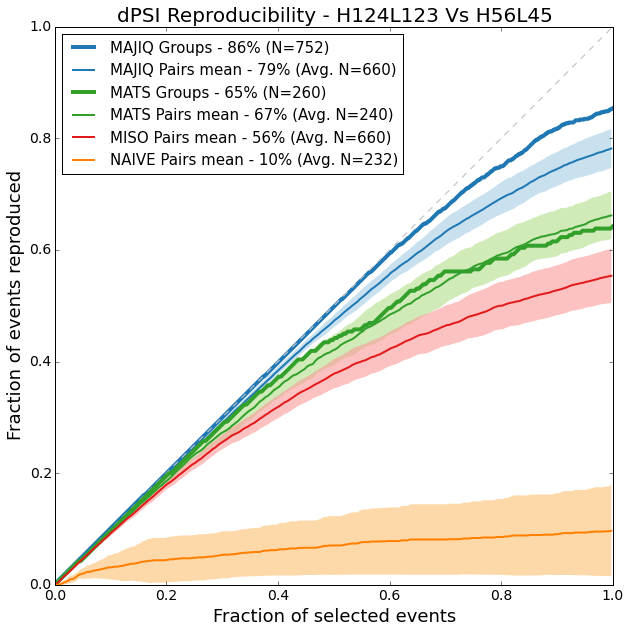

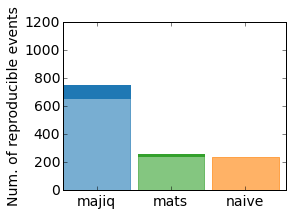

In [150]:
args_to_parse = '../data/fig2_D/ranks_V20 --groupfolder H124L123H56L45 --plotpath ./plots/fig2D/ --plotname reproducibility --methods majiq mats miso naive'
main(args_to_parse=args_to_parse.split())

#### Figure 2 - Supp.2Ai - $\Delta\Psi$ Reproducibility for Splicing Events with $|E(\Delta\Psi)|>=0.15\ \&\ FDR <= 0.05$

Processing majiq ...
[majiq] Avg. N=728.67
[majiq group] N=879
Processing mats ...
[mats] Avg. N=312.33
[mats group] N=342
Processing miso ...
[miso] Avg. N=728.67
Processing naive ...
[naive] Avg. N=338.67


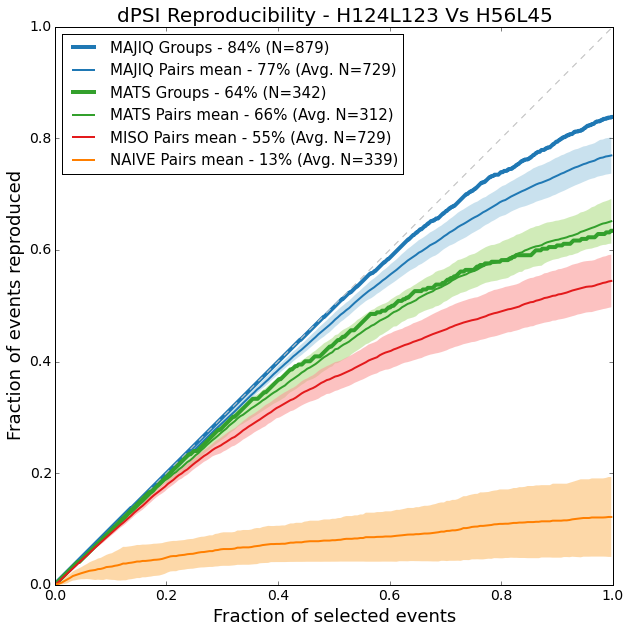

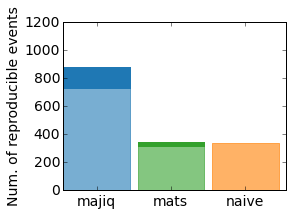

In [151]:
args_to_parse = '../data/fig2_D/ranks_V15 --groupfolder H124L123H56L45 --plotpath ./plots/fig2D/ --plotname reproducibility_0.15 --methods majiq mats miso naive'
main(args_to_parse=args_to_parse.split())

#### Figure 2 - Supp.2Aii - $\Delta\Psi$ Reproducibility for Splicing Events with $|E(\Delta\Psi)|>=0.10\ \&\ FDR <= 0.05$

Processing majiq ...
[majiq] Avg. N=784.33
[majiq group] N=986
Processing mats ...
[mats] Avg. N=428.00
[mats group] N=480
Processing miso ...
[miso] Avg. N=784.33
Processing naive ...
[naive] Avg. N=564.00


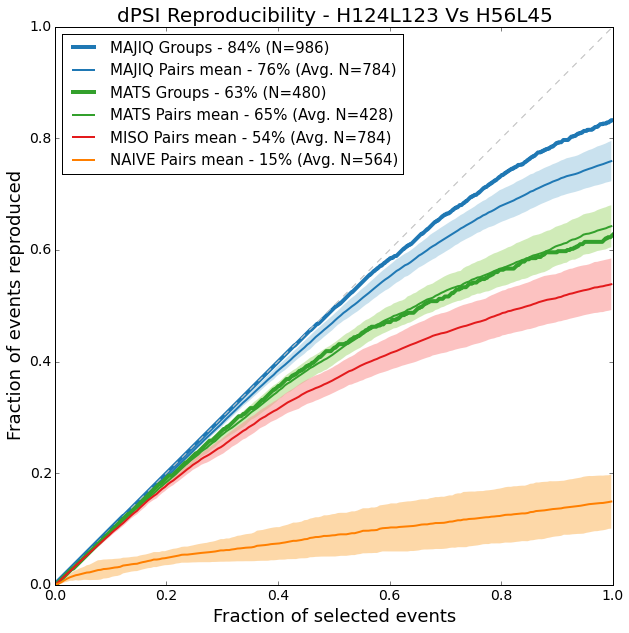

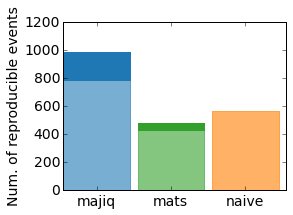

In [152]:
args_to_parse = '../data/fig2_D/ranks_V10 --groupfolder H124L123H56L45 --plotpath ./plots/fig2D/ --plotname reproducibility_0.1 --methods majiq mats miso naive'
main(args_to_parse=args_to_parse.split())